[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Denis-R-V/TSR/blob/main/simple_detector_v2.ipynb)

# Система распознавания дорожных знаков на датасете RTSD

## Детектор. Инференс и метрики

In [1]:
colab = False

if colab == True:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install fiftyone
if colab == True:
    dataset_path = '.'
    checkpoints_path = '../content/drive/MyDrive/TSR/checkpoints'
else:
    dataset_path = 'data'
    checkpoints_path = 'checkpoints'

import json
import os
#import numpy as np 
#import pandas as pd 
import random
import time

#import cv2
import torch
#import torch.utils.data
#from torch.utils.data import Dataset, DataLoader
import torchvision
#import torchvision.transforms as transforms
from torchvision.transforms import functional as func       # ?
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
#from torchvision.models.detection import FasterRCNN

from PIL import Image
import matplotlib.pyplot as plt
#import matplotlib.patches as patches
%matplotlib inline

#from pycocotools.coco import COCO
import fiftyone as fo

### Загрузка графиков потерь по эпохам

In [ ]:
device_id = 0
if torch.cuda.is_available() == True:
    device = f'cuda:{device_id}'
#elif torch.backends.mps.is_available() == True:
#    device = 'mps'
else:
    device = 'cpu'

### Графики лоссов моделей mobilenet v3 320 и mobilenet v3 (размер батча 8)

In [125]:
def get_plot_models(last_epoch, list_models, width_plot=10):
    
    # количество моделей
    n_models = len(list_models) 

    # Строим графики для resnet50_b8 и resnet50_v2_b8
    fig, ax = plt.subplots(nrows=1,ncols=n_models, sharey=True) 
    #for i in range(n_models):
    #    locals()['ax'+str(i+1)] = ax.flatten()

    for i in range(2):
        # Загрузки лоссов из чекпойнта
        model_name = list_models[i]
        checkpoint = torch.load(os.path.join(checkpoints_path, f'chkpt_detector_{model_name}_{last_epoch}.pth'), map_location=device)
        train_losses = checkpoint['losses_train']
        val_losses = checkpoint['losses_val']
        # построение графиков
        ax[i].plot(train_losses, label='Train')
        ax[i].plot(val_losses, label='Val')
        ax[i].set_title(model_name)
        ax[i].set(xlabel='Epoch', ylabel='Loss')
        ax[i].legend()

    fig.set_size_inches(width_plot, 3)
    plt.subplots_adjust(hspace=0,wspace=0.1)
    plt.show()
    return None

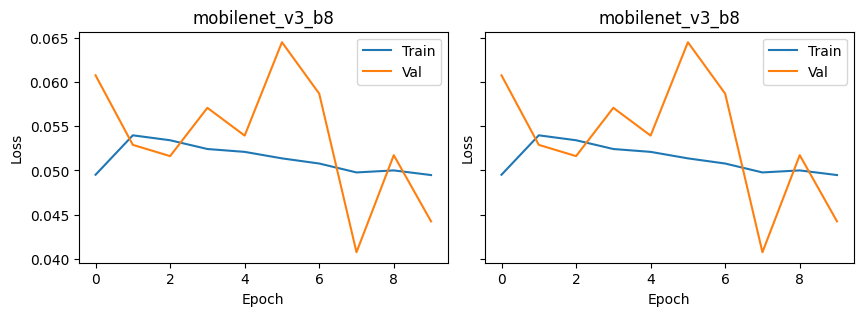

In [123]:
# Графики лоссов моделей mobilenet_v3_320_b8 и mobilenet_v3_b8 (размер батча 8)
#get_plot_models(last_epoch = 9, list_models = ['mobilenet_v3_320_b8', 'mobilenet_v3_b8'])
get_plot_models(last_epoch = 9, list_models = ['mobilenet_v3_b8', 'mobilenet_v3_b8'])

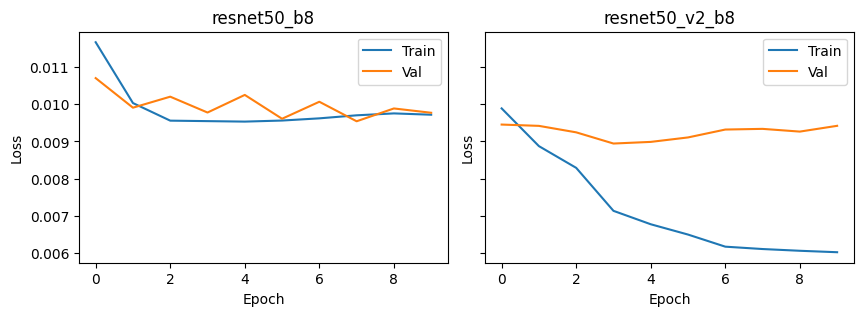

In [126]:
# Графики лоссов моделей resnet50 и resnet50_v2 (размер батча 8)
get_plot_models(last_epoch = 9, list_models = ['resnet50_b8', 'resnet50_v2_b8'])

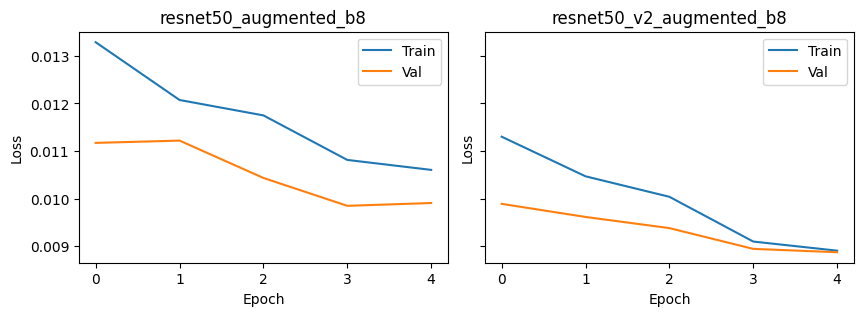

In [127]:
# Графики лоссов моделей resnet50 и resnet50_v2 с аугментацией (размер батча 8)
get_plot_models(last_epoch = 4, list_models = ['resnet50_augmented_b8', 'resnet50_v2_augmented_b8'])

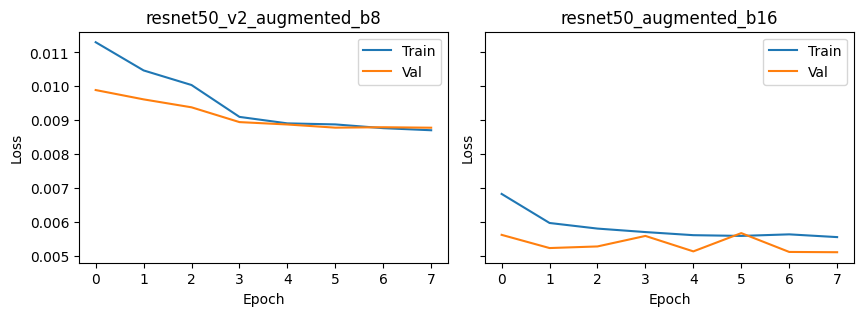

In [130]:
# Графики лоссов моделей resnet50 и resnet50_v2 с аугментацией (размер батча 16)
get_plot_models(last_epoch = 7, list_models = ['resnet50_v2_augmented_b8', 'resnet50_augmented_b16'])

### Общие параметры

In [ ]:
device_id = 0
if torch.cuda.is_available() == True:
    device = f'cuda:{device_id}'
#elif torch.backends.mps.is_available() == True:
#    device = 'mps'
else:
    device = 'cpu'

#model_name = 'mobilenet_v3_320_b8'          # еще не обучена
#model_name = 'mobilenet_v3_b8'
#model_name = 'resnet50_b8'
#model_name = 'resnet50_v2_b8'
#model_name = 'resnet50_augmented_b8'
#model_name = 'resnet50_v2_augmented_b8'
model_name = 'resnet50_augmented_b16'
#model_name = 'resnet50_v2_augmented_b16'

### График потерь для выбранного графика

In [ ]:
# последняя эпоха для загрузки параметров
last_epoch = 9      

# Загрузки лоссов из чекпойнта
checkpoint = torch.load(os.path.join(checkpoints_path, f'chkpt_detector_{model_name}_{last_epoch}.pth'), map_location=device)
train_losses = checkpoint['losses_train']
val_losses = checkpoint['losses_val']

# Эпоха с наименьшим loss на валидационной выборке
min_loss = min(val_losses)
for i in range(len(val_losses)):
    if val_losses[i] == min_loss:
        epoch_min_loss = i
        break
del checkpoint
print(f"Для модели {model_name} loss для {epoch_min_loss} эпохи составляет {min_loss}")

# Построение графика
fig, ax = plt.subplots()
ax.plot(train_losses, label='Train')
ax.plot(val_losses, label='Val')
ax.set(xlabel='Epoch', ylabel='Loss')
ax.legend()
plt.show()

### Загрузка модели и параметров

In [15]:
def load_model_detection(model_name, num_classes, epoch):
    # load model
    if (model_name == 'resnet50_b8') or (model_name == 'resnet50_augmented_b8') or (model_name == 'resnet50_augmented_b16'):
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)
        print("Загружена модель resnet50")
    elif (model_name == 'resnet50_v2_b8') or (model_name == 'resnet50_v2_augmented_b8') or (model_name == 'resnet50_v2_augmented_b16'):
        model =torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights=None)
        print("Загружена модель resnet50_v2")
    elif model_name == 'mobilenet_v3_b8':
        model =torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(weights=None)
        print("Загружена модель mobilenet_v3")
    elif model_name == 'mobilenet_v3_320_b8':    
        model =torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(weights=None)
        print("Загружена модель mobilenet_v3_320")
    else:
        print("Неверно указано название модели")
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    # Загрузка весов модели
    checkpoint = torch.load(os.path.join(checkpoints_path, f'chkpt_detector_{model_name}_{epoch}.pth'), map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Для модели {model_name} загружены веса эпохи {epoch}")
    return model

In [37]:
epoch = None       # выбираем эпоху для загрузки весов (если не указана - берем эпоху с наименьшем лоссом)
if epoch is None:
    epoch = epoch_min_loss
    
model = load_model_detection(model_name, num_classes=2, epoch=epoch).to(device)

Загружена модель mobilenet_v3
Для модели mobilenet_v3_b8 загружены веса эпохи 7


### Детекция знаков на одном изображении

In [39]:
def get_prediction_one_image(img_path, img_name, threshold):
    model.eval()
    img = Image.open(os.path.join(img_path, img_name))
    transforms=torchvision.transforms.ToTensor()
    img = transforms(img).to(device)
    
    prediction = model([img])
    pred_boxes = [[i[0], i[1], i[2], i[3]] for i in list(prediction[0]['boxes'].detach().cpu().numpy())]
    pred_labels = list(prediction[0].get('labels').cpu().numpy())
    pred_scores = list(prediction[0].get('scores').detach().cpu().numpy())
    pred_tr = [pred_scores.index(x) for x in pred_scores if x > threshold][-1]
    pred_labels = pred_labels[:pred_tr+1]
    pred_boxes = pred_boxes[:pred_tr+1]
    pred_scores = pred_scores[:pred_tr+1]
    
    #boxes = []
    #for i in range(num_objs):
    #    min = coco_annotation[i]['bbox'][0]
    #    ymin = coco_annotation[i]['bbox'][1]
    #    xmax = xmin + coco_annotation[i]['bbox'][2]
    #    ymax = ymin + coco_annotation[i]['bbox'][3]
    #    boxes.append([xmin, ymin, xmax, ymax])
    
    return pred_boxes, pred_labels, pred_scores


time_start = time.time()
img_name = 'rtsd-frames/autosave16_10_2012_08_58_25_5.jpg'
threshold = 0.1
prediction = get_prediction_one_image(dataset_path, img_name, threshold)
time_end = time.time()
prediction, time_end-time_start


(([[1145.488, 11.640286, 1268.7133, 147.97311],
   [1170.4459, 142.14598, 1280.0, 243.37715]],
  [1, 1],
  [0.99661225, 0.15971474]),
 0.23687100410461426)

In [40]:
time_inference = []
for i in range(1000):
    time_start = time.time()
    img_name = 'rtsd-frames/autosave16_10_2012_08_58_25_5.jpg'
    threshold = 0.1
    prediction = get_prediction_one_image(dataset_path, img_name, threshold)
    time_end = time.time()
    time_inference.append(time_end-time_start)
    prediction, time_end-time_start
min(time_inference), max(time_inference)

(0.03291201591491699, 0.0937495231628418)

In [19]:
def get_predict_anno(images_path, img_name, threshold):

    if img_name == None:
        with open(os.path.join(dataset_path, 'val_anno.json'), 'r') as read_file:
            val_anno = json.load(read_file)
        read_file.close()
        img_name = val_anno.get('images')[random.randint(0, len(val_anno.get('images')))].get('file_name')

    pred_boxes, pred_labels, pred_scores = get_prediction_one_image(images_path, img_name, threshold)
    
    anno = {}

    images = []
    image_item = {}
    image_item['id'] = 0
    img = Image.open(os.path.join(images_path, img_name))
    transforms=torchvision.transforms.ToTensor()
    img = transforms(img).to(device)
    image_item['width'] = img.shape[2]
    image_item['height'] = img.shape[1]
    image_item['file_name'] = img_name
    images.append(image_item)
    anno['images'] = images

    annotations = []
    for i in range(len(pred_boxes)):
        anno_item = {}
        anno_item['id'] = i
        anno_item['image_id'] = 0
        anno_item['category_id'] = int(pred_labels[i])
    

    with open(os.path.join(dataset_path, 'predicted_anno.json'), 'w') as f:
        json.dump(anno, f)#ensure_ascii=False, indent=4)
    f.close()

    # загрузка изображения в fiftyone
    data_path = images_path      # можно не указывать, если в JSON путь совпадает

    # The path yo the COCO labels JSON file
    labels_file = "train_anno_bin_class.json"
    labels_path = os.path.join(dataset_path, 'predicted_anno.json')


    # Import the dataset
    dataset = fo.Dataset.from_dir(
        dataset_type=fo.types.COCODetectionDataset,
        data_path=data_path,
        labels_path=labels_path
    )
    # Визуализация набора данных
    session = fo.launch_app(dataset)

    return anno

In [ ]:
threshold = 0.5
#img_name = None
img_name = 'rtsd-frames/autosave13_04_2013_09_48_32_2.jpg'
#img_name = 'rtsd-frames/autosave16_10_2012_08_58_25_5.jpg'
#img_name = 'rtsd-frames/autosave01_02_2012_09_24_03.jpg'
#prediction_anno = get_predict_anno(dataset_path, , threshold)
prediction_anno = get_predict_anno(dataset_path, img_name, threshold)


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds



### Детекция знаков на списке изображений

In [21]:
def get_prediction_list_images(images_path, img_list, threshold):
    model.eval()
    transforms=torchvision.transforms.ToTensor()
    images = []
    for image in img_list:
        img = Image.open(os.path.join(images_path, image)) 
        img = transforms(img).to(device)
        images.append(img)
            
    predictions = model(images)
    
    results = []
    for prediction in predictions:
        result = []
        pred_boxes = [[i[0], i[1], i[2], i[3]] for i in list(prediction['boxes'].detach().cpu().numpy())]
        pred_labels = list(prediction.get('labels').cpu().numpy())
        pred_scores = list(prediction.get('scores').detach().cpu().numpy())

        pred_tr = [pred_scores.index(x) for x in pred_scores if x > threshold][-1]
        pred_labels = pred_labels[:pred_tr+1]
        pred_boxes = pred_boxes[:pred_tr+1]
        pred_scores = pred_scores[:pred_tr+1]
        result.append(pred_boxes)
        result.append(pred_labels)
        result.append(pred_scores)
        results.append(result)
    #boxes = []
    #for i in range(num_objs):
    #    min = coco_annotation[i]['bbox'][0]
    #    ymin = coco_annotation[i]['bbox'][1]
    #    xmax = xmin + coco_annotation[i]['bbox'][2]
    #    ymax = ymin + coco_annotation[i]['bbox'][3]
    #    boxes.append([xmin, ymin, xmax, ymax])
    
    return results#pred_boxes, pred_labels, pred_scores

time_start = time.time()
img_list = ['rtsd-frames/autosave16_10_2012_08_58_25_5.jpg',
            'rtsd-frames/autosave01_02_2012_09_24_03.jpg']
threshold = 0.1
prediction = get_prediction_list_images(dataset_path, img_list, threshold)
time_end = time.time()
prediction, time_end-time_start

([[[[1142.5594, 9.751048, 1275.8434, 148.46223]], [1], [0.99598134]],
  [[[1148.6593, 255.2714, 1213.5939, 319.6889]], [1], [0.9981343]]],
 7.109411716461182)

In [26]:
threshold = 0.5
#img_name = None
img_name = 'rtsd-frames/autosave13_04_2013_09_48_32_2.jpg'
#img_name = 'rtsd-frames/autosave16_10_2012_08_58_25_5.jpg'
#img_name = 'rtsd-frames/autosave01_02_2012_09_24_03.jpg'
#prediction_anno = get_predict_anno(dataset_path, , threshold)
prediction_anno = get_predict_anno(dataset_path, img_name, threshold)

 100% |███████████████████| 15/15 [87.8ms elapsed, 0s remaining, 170.8 samples/s]     


### Детекция знаков на списке изображений

In [143]:
def get_prediction_list_images(images_path, img_list, threshold):
    model.eval()
    transforms=torchvision.transforms.ToTensor()
    images = []
    for image in img_list:
        img = Image.open(os.path.join(images_path, image)) 
        img = transforms(img).to(device)
        images.append(img)
            
    predictions = model(images)
    
    results = []
    for prediction in predictions:
        result = []
        pred_boxes = [[i[0], i[1], i[2], i[3]] for i in list(prediction['boxes'].detach().cpu().numpy())]
        pred_labels = list(prediction.get('labels').cpu().numpy())
        pred_scores = list(prediction.get('scores').detach().cpu().numpy())

        pred_tr = [pred_scores.index(x) for x in pred_scores if x > threshold][-1]
        pred_labels = pred_labels[:pred_tr+1]
        pred_boxes = pred_boxes[:pred_tr+1]
        pred_scores = pred_scores[:pred_tr+1]
        result.append(pred_boxes)
        result.append(pred_labels)
        result.append(pred_scores)
        results.append(result)
    #boxes = []
    #for i in range(num_objs):
    #    min = coco_annotation[i]['bbox'][0]
    #    ymin = coco_annotation[i]['bbox'][1]
    #    xmax = xmin + coco_annotation[i]['bbox'][2]
    #    ymax = ymin + coco_annotation[i]['bbox'][3]
    #    boxes.append([xmin, ymin, xmax, ymax])
    
    return results#pred_boxes, pred_labels, pred_scores

time_start = time.time()
img_list = ['rtsd-frames/autosave16_10_2012_08_58_25_5.jpg',
            'rtsd-frames/autosave01_02_2012_09_24_03.jpg']
threshold = 0.1
prediction = get_prediction_list_images(dataset_path, img_list, threshold)
time_end = time.time()
prediction, time_end-time_start

([[[[1142.6166, 9.81129, 1275.8557, 148.39183]], [1], [0.99602306]],
  [[[1148.6719, 255.20079, 1213.5051, 319.62186]], [1], [0.9980149]]],
 0.3670172691345215)

In [180]:
def get_predict_anno_list_images(images_path, img_list, threshold):

    if img_list == None:
        with open(os.path.join(dataset_path, 'val_anno.json'), 'r') as read_file:
            val_anno = json.load(read_file)
        read_file.close()
        img_list = [val_anno.get('images')[random.randint(0, len(val_anno.get('images')))].get('file_name')]

    predict = []
    for image in img_list:
        one_predict = get_prediction_one_image(dataset_path, image, threshold)
        predict.append(one_predict)
    anno = {}
    anno_item_id = 0

    transforms=torchvision.transforms.ToTensor()
    images = []
    annotations = []
    for i in range(len(predict)):
        img = Image.open(os.path.join(images_path, img_list[i]))
        img = transforms(img).to(device)
        
        image_item = {}
        image_item['id'] = i
        image_item['width'] = img.shape[2]
        image_item['height'] = img.shape[1]
        image_item['file_name'] = img_list[i]
        images.append(image_item)

        prediction = predict[i]
        for j in range(len(prediction[0])):
            
            anno_item = {}
            anno_item['id'] = anno_item_id
            anno_item_id += 1
            anno_item['image_id'] = i
            anno_item['category_id'] = int(prediction[1][j])
            anno_item['area'] = (float(prediction[0][j][2]) - float(prediction[0][j][0]))*(float(prediction[0][j][3]) - float(prediction[0][j][1]))
            anno_item['bbox'] = [float(prediction[0][j][0]), float(prediction[0][j][1]), float(prediction[0][j][2]) - float(prediction[0][j][0]), float(prediction[0][j][3]) - float(prediction[0][j][1])]
            anno_item['iscrowd'] = 0
            annotations.append(anno_item)
    
    anno['images'] = images
    anno['annotations'] = annotations
    anno['categories'] = [{'id': 1, 'name': 'sign'}]


    result = predict

    with open(os.path.join(dataset_path, 'predicted_anno.json'), 'w') as f:
        json.dump(anno, f)#ensure_ascii=False, indent=4)
    f.close()

    # загрузка изображения в fiftyone
    data_path = images_path      # можно не указывать, если в JSON путь совпадает

    # The path yo the COCO labels JSON file
    labels_path = os.path.join(dataset_path, 'predicted_anno.json')


    # Import the dataset
    dataset = fo.Dataset.from_dir(
        dataset_type=fo.types.COCODetectionDataset,
        data_path=data_path,
        labels_path=labels_path
    )
    # Визуализация набора данных
    session = fo.launch_app(dataset)

    return result#annotations


threshold = 0.1
img_list = ['image_for_predict/image1.jpg',                     # картинка из интернета
            'image_for_predict/image2.jpg',                     # картинка из интернета
            'image_for_predict/screen1.jpg',                    # скрин я яндекс карт
            'image_for_predict/screen2.jpg',                    # скрин я яндекс карт
            'image_for_predict/p20_1.jpg',                      # снимок из окна кабинета
            'image_for_predict/p20_2.jpg',                      # снимок из окна кабинета
            'image_for_predict/p20_3.jpg',                      # снимок из окна кабинета
            'image_for_predict/p20_4.jpg',                      # снимок из окна кабинета
            'image_for_predict/p20_5.jpg',                      # снимок из окна кабинета
            'image_for_predict/p20_6.jpg',                      # снимок из окна кабинета
            'image_for_predict/p20_7.jpg',                      # снимок из окна кабинета
            'image_for_predict/p20_8.jpg',                      # снимок из окна кабинета
            'image_for_predict/p20_9.jpg',                      # снимок из окна кабинета
            'rtsd-frames/autosave16_10_2012_08_58_25_5.jpg',    # тестовая выборка
            'rtsd-frames/autosave01_02_2012_09_24_03.jpg'       # тестовая выборка 
            ]

#prediction_anno = get_predict_anno_list_images(dataset_path, None, threshold)
prediction_anno = get_predict_anno_list_images(dataset_path, img_list, threshold)
prediction_anno

[([[621.8252, 180.98128, 663.4464, 221.60262],
   [667.6, 197.60684, 702.5739, 233.166],
   [516.61914, 317.14456, 588.3488, 388.88318],
   [526.03656, 156.91898, 556.4048, 188.08212],
   [524.70447, 417.12906, 581.09595, 475.47787],
   [468.15247, 162.72331, 506.20023, 201.94803],
   [423.7199, 168.90741, 456.23047, 201.54187],
   [518.616, 253.29434, 585.1723, 316.45462],
   [526.04364, 189.43, 554.5289, 217.47488],
   [758.75287, 135.94685, 779.6427, 158.1459],
   [623.4799, 241.21997, 664.35535, 282.19626],
   [668.44635, 164.67198, 702.72406, 196.57976],
   [814.0648, 141.71248, 837.706, 165.25223],
   [524.8704, 389.46146, 580.46356, 417.09302],
   [603.34644, 294.07242, 687.518, 379.7005],
   [713.8019, 159.30682, 744.2345, 196.20515],
   [672.9941, 259.16406, 734.40094, 322.25858],
   [239.12863, 230.51071, 269.64633, 260.3547],
   [793.9456, 117.29539, 812.81305, 135.96732],
   [815.36554, 107.98954, 829.6852, 122.296036],
   [621.9749, 221.59914, 662.0605, 240.84181],
   [526


Could not connect session, trying again in 10 seconds

Could not connect session, trying again in 10 seconds



Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds



### Рассчет метрик модели на валидационной выборке

Загрузка валидационного датасета

In [28]:
#Load val dataset COCO

# The directiry containing the source images
data_path = dataset_path      # можно не указывать, если в JSON путь совпадает

# The path yo the COCO labels JSON file
val_anno_file = "val_anno_bin_class.json"
val_anno_path = os.path.join(dataset_path, val_anno_file)

# Import the dataset
val_dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path=data_path,
    labels_path=val_anno_path
)

In [29]:
predictions_view = val_dataset.take(50, seed=42)

In [31]:
# Add and evaluating Faster-RCNN detections
# Faster-RCNN detections can be calculated and added to every sample of the dataset in a new field


'''# Load the pretrained PyTorch model
def load_model_detection(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model =torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

num_classes = 2
model = load_model_detection(num_classes)

# Run the model on GPU if it is available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Загрузка весов модели
checkpoint = torch.load('checkpoints/chkpt_detector_resnet50_augmented_2.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()'''

classes = predictions_view.default_classes

# Add predictions
n=0
for sample in predictions_view:
    image = Image.open(sample.filepath)
    image = func.to_tensor(image).to(device)
    c,h,w = image.shape
    preds = model([image])[0]
    labels = preds['labels'].cpu().detach().numpy()
    scores = preds['scores'].cpu().detach().numpy()
    boxes = preds['boxes'].cpu().detach().numpy()
    detections = []
    for label, score, box in zip (labels, scores, boxes):
        # Compute relative bounding box coordinates
        x1, y1, x2, y2 = box
        rel_box = [x1/w, y1/h, (x2-x1)/w, (y2-y1)/h]
        detections.append(fo.Detection(label=classes[label],
                                        bounding_box=rel_box,
                                        confidence=score
                                        )
                            )
    sample['faster_rcnn'] = fo.Detections(detections=detections)
    sample.save()

In [32]:
session = fo.launch_app(predictions_view)

In [41]:
# Evaluate the predictions in the `faster_rcnn` field of our `high_conf_view`
# with respect to the objects in the `ground_truth` field
def get_metrics():
    results = predictions_view.evaluate_detections(
        "faster_rcnn",
        gt_field="detections",
        eval_key="eval",
        compute_mAP=True,
    )
    model_metrics = results.metrics()
    model_metrics['mAP'] = results.mAP()
    return model_metrics
detector_resnet50_augmented_metrics = get_metrics()
detector_resnet50_augmented_metrics

Evaluating detections...
Performing IoU sweep...


{'accuracy': 0.53125,
 'precision': 0.53125,
 'recall': 1.0,
 'fscore': 0.6938775510204082,
 'support': 85,
 'mAP': 0.6730619438905321}